### Importing Modules

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as mno
from sklearn.model_selection import train_test_split
from scipy.sparse.linalg import svds

from surprise import Dataset,Reader
from surprise import SVD, KNNWithMeans
from surprise import accuracy

%matplotlib inline

In [2]:
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None
pd.options.display.float_format = '{:.7f}'.format
pd.options.display.max_rows = None

print("Desired Options Set for Working!!")

Desired Options Set for Working!!


**Data From : http://jmcauley.ucsd.edu/data/amazon/**

In [3]:
data = pd.read_csv("Data-Asset/Electronics_ratings.csv")

In [4]:
print(data.head())
print("--------------------------")
print("Data has {} rows & {} columns".format(data.shape[0],data.shape[1]))

          user_id  product_id    rating   timestamp
0   AKM1MP6P0OYPR  0132793040 5.0000000  1365811200
1  A2CX7LUOHB2NDG  0321732944 5.0000000  1341100800
2  A2NWSAGRHCP8N5  0439886341 1.0000000  1367193600
3  A2WNBOD3WNDNKT  0439886341 3.0000000  1374451200
4  A1GI0U4ZRJA8WN  0439886341 1.0000000  1334707200
--------------------------
Data has 7824482 rows & 4 columns


There is around 7.8 M datapoints hence, we're taking top 10% ~ 782.4 K data points for our analysis 

In [5]:
data_new = data.iloc[:round(0.1*data.shape[0]),:]
print(data_new.head())
print("--------------------------")
print("New Data has {} rows & {} columns".format(data_new.shape[0],data_new.shape[1]))

          user_id  product_id    rating   timestamp
0   AKM1MP6P0OYPR  0132793040 5.0000000  1365811200
1  A2CX7LUOHB2NDG  0321732944 5.0000000  1341100800
2  A2NWSAGRHCP8N5  0439886341 1.0000000  1367193600
3  A2WNBOD3WNDNKT  0439886341 3.0000000  1374451200
4  A1GI0U4ZRJA8WN  0439886341 1.0000000  1334707200
--------------------------
New Data has 782448 rows & 4 columns


In [6]:
print("Datatypes of columns : ")
print("--------------------------")
print(data_new.dtypes)

Datatypes of columns : 
--------------------------
user_id        object
product_id     object
rating        float64
timestamp       int64
dtype: object


Timestamp column is not required, hence Dropping it!!

In [7]:
data_new.drop(['timestamp'], axis = 1, inplace = True)
print("New Data has {} rows & {} columns".format(data_new.shape[0],data_new.shape[1]))

New Data has 782448 rows & 3 columns


In [8]:
print("Info for the Dataset : ")
print("--------------------------")
data_new.info()

Info for the Dataset : 
--------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 782448 entries, 0 to 782447
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     782448 non-null  object 
 1   product_id  782448 non-null  object 
 2   rating      782448 non-null  float64
dtypes: float64(1), object(2)
memory usage: 17.9+ MB


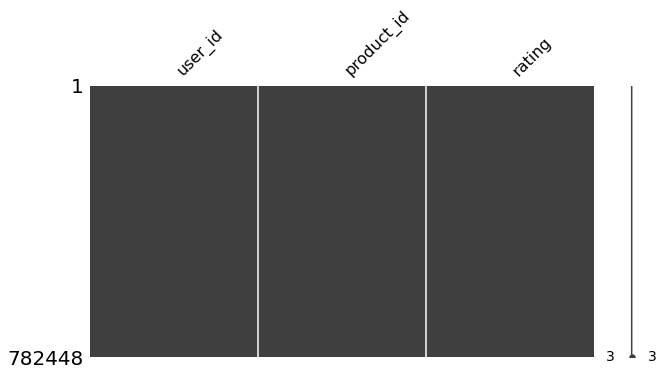

In [9]:
mno.matrix(data_new, figsize = (10, 5));

### EDA

In [10]:
print(data_new.describe())

              rating
count 782448.0000000
mean       3.9819541
std        1.3961327
min        1.0000000
25%        3.0000000
50%        5.0000000
75%        5.0000000
max        5.0000000


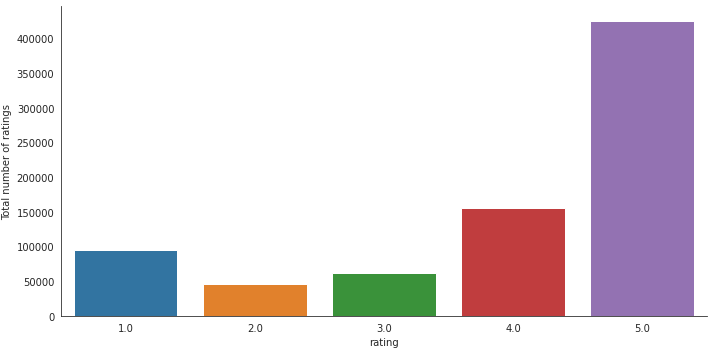

In [11]:
with sns.axes_style('white'):
    g = sns.factorplot("rating", data=data_new, aspect=2.0, kind='count');
    g.set_ylabels("Total number of ratings") 

In [12]:
for rating in sorted(data_new["rating"].unique()):
    print("Number of users who rated {} rating are : {}".format(rating,data_new[data_new["rating"]==rating].shape[0]))

Number of users who rated 1.0 rating are : 94850
Number of users who rated 2.0 rating are : 46287
Number of users who rated 3.0 rating are : 61794
Number of users who rated 4.0 rating are : 154719
Number of users who rated 5.0 rating are : 424798


In [13]:
print("No. of unique Users : {}".format(data_new["user_id"].nunique()))
print("No. of unique Products : {}".format(data_new["product_id"].nunique()))

No. of unique Users : 606149
No. of unique Products : 47105


In [14]:
#Top 10 most active users
most_rated_users = data_new.groupby("user_id").size().sort_values(ascending=False)[:10]
most_rated_users

user_id
A5JLAU2ARJ0BO     384
A231WM2Z2JL0U3    249
A25HBO5V8S8SEA    163
A6FIAB28IS79      113
AT6CZDCP4TRGA     112
AKT8TGIT6VVZ5     108
A11D1KHM7DVOQK    106
A2B7BUH8834Y6M     98
A2AEZQ3DGBBLPR     81
A2R6RA8FRBS608     79
dtype: int64

In [15]:
#Top 10 most rated products
most_rated_prods = data_new.groupby("product_id").size().sort_values(ascending = False)[:10]
most_rated_prods

product_id
B0002L5R78    9487
B0001FTVEK    5345
B000BQ7GW8    4275
B00007E7JU    3523
B000BKJZ9Q    3219
B000B9RI14    2996
B000A6PPOK    2828
B00007M1TZ    2608
B00004ZCJE    2547
B000652M6Y    2152
dtype: int64

In [16]:
users_count = data_new["user_id"].value_counts()
sampled_data = data_new[data_new["user_id"].isin(users_count[users_count>=50].index)]

In [17]:
print("No. of users who gave 50 or more rating : {}".format(sampled_data.shape[0]))

No. of users who gave 50 or more rating : 2550


In [18]:
print("No. of unique users in sampled data : {}".format(sampled_data["user_id"].nunique()))
print("No. of unique products in sampled data : {}".format(sampled_data["product_id"].nunique()))

No. of unique users in sampled data : 27
No. of unique products in sampled data : 2207


In [19]:
rating_matrix = sampled_data.pivot(index="user_id",
                                   columns="product_id", 
                                   values="rating")

In [20]:
rating_matrix.head(10)

product_id      1400532655  B000000O48  B000001OL6  B000001OMN  B00000J05A  \
user_id                                                                      
A11D1KHM7DVOQK         NaN         NaN         NaN   2.0000000         NaN   
A12DLJESJKM1OQ         NaN         NaN         NaN         NaN         NaN   
A149RNR5RH19YY         NaN         NaN         NaN         NaN         NaN   
A1F9Z42CFF9IAY         NaN         NaN         NaN         NaN         NaN   
A1FR68QH6Z4YZM         NaN         NaN         NaN         NaN         NaN   
A1JWSDDIH5Z7DV         NaN         NaN         NaN         NaN         NaN   
A1MJMYLRTZ76ZX         NaN         NaN         NaN         NaN         NaN   
A1RPTVW5VEOSI          NaN         NaN         NaN         NaN         NaN   
A203OCQQ12MAVT         NaN         NaN         NaN         NaN         NaN   
A231WM2Z2JL0U3         NaN         NaN         NaN         NaN         NaN   

product_id      B00000J061  B00000J0E8  B00000J1E6  B00000J1EP  B00000J1G6  \
user_id                                                                      
A11D1KHM7DVOQK         NaN         NaN         NaN         NaN   1.0000000   
A12DLJESJKM1OQ         NaN         NaN         NaN         NaN         NaN   
A149RNR5RH19YY         NaN         NaN         NaN         NaN         NaN   
A1F9Z42CFF9IAY         NaN         NaN         NaN         NaN         NaN   
A1FR68QH6Z4YZM         NaN         NaN         NaN         NaN         NaN   
A1JWSDDIH5Z7DV         NaN         NaN         NaN         NaN         NaN   
A1MJMYLRTZ76ZX         NaN         NaN         NaN         NaN         NaN   
A1RPTVW5VEOSI    5.0000000         NaN         NaN         NaN         NaN   
A203OCQQ12MAVT         NaN         NaN         NaN         NaN         NaN   
A231WM2Z2JL0U3         NaN         NaN         NaN         NaN         NaN   

product_id      B00000J1TX  B00000J1UQ  B00000J1US  B00000J1UU  B00000J3II  \
user_id                                                                      
A11D1KHM7DVOQK         NaN         NaN         NaN         NaN         NaN   
A12DLJESJKM1OQ         NaN         NaN         NaN         NaN         NaN   
A149RNR5RH19YY         NaN         NaN         NaN         NaN         NaN   
A1F9Z42CFF9IAY         NaN         NaN         NaN         NaN         NaN   
A1FR68QH6Z4YZM         NaN         NaN         NaN         NaN         NaN   
A1JWSDDIH5Z7DV         NaN         NaN         NaN         NaN         NaN   
A1MJMYLRTZ76ZX         NaN         NaN         NaN         NaN         NaN   
A1RPTVW5VEOSI          NaN         NaN         NaN         NaN         NaN   
A203OCQQ12MAVT         NaN         NaN         NaN         NaN         NaN   
A231WM2Z2JL0U3         NaN         NaN   5.0000000         NaN         NaN   

product_id      B00000J3NG  B00000J434  B00000J49I  B00000J4CY  B00000J4FS  \
user_id                                                                      
A11D1KHM7DVOQK         NaN         NaN         NaN         NaN         NaN   
A12DLJESJKM1OQ         NaN         NaN         NaN         NaN         NaN   
A149RNR5RH19YY         NaN         NaN         NaN         NaN         NaN   
A1F9Z42CFF9IAY         NaN         NaN         NaN         NaN         NaN   
A1FR68QH6Z4YZM         NaN         NaN         NaN         NaN         NaN   
A1JWSDDIH5Z7DV         NaN         NaN         NaN         NaN         NaN   
A1MJMYLRTZ76ZX         NaN   4.0000000         NaN         NaN         NaN   
A1RPTVW5VEOSI          NaN         NaN         NaN         NaN         NaN   
A203OCQQ12MAVT         NaN         NaN         NaN         NaN         NaN   
A231WM2Z2JL0U3         NaN         NaN         NaN         NaN         NaN   

product_id      B00000J4IX  B00000J570  B00000J9Z7  B00000JBAM  B00000JBIA  \
user_id                                                                      
A11D1KHM7DVOQK         NaN         NaN   4.0000000         NaN         NaN   
A12DLJESJKM1OQ    

### Finding Density of The Rating Matrix

In [21]:
rating_matrix = rating_matrix.fillna(0)
print("Shape of rating matrix : {}".format(rating_matrix.shape))

total_user_rating = np.count_nonzero(rating_matrix)
print("Total user Rating : {}".format(total_user_rating))

total_possible_rating = rating_matrix.shape[0]*rating_matrix.shape[1]
print("Total possible Rating : {}".format(total_possible_rating))

density = (total_user_rating/total_possible_rating)*100
print("Density of Matrix : {}%".format(round(density,2)))

Shape of rating matrix : (27, 2207)
Total user Rating : 2550
Total possible Rating : 59589
Density of Matrix : 4.28%


### Rating Matrix (For User Based Collaborative Filtering)

In [22]:
rating_matrix.iloc[:5,:]

product_id      1400532655  B000000O48  B000001OL6  B000001OMN  B00000J05A  \
user_id                                                                      
A11D1KHM7DVOQK   0.0000000   0.0000000   0.0000000   2.0000000   0.0000000   
A12DLJESJKM1OQ   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A149RNR5RH19YY   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A1F9Z42CFF9IAY   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A1FR68QH6Z4YZM   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   

product_id      B00000J061  B00000J0E8  B00000J1E6  B00000J1EP  B00000J1G6  \
user_id                                                                      
A11D1KHM7DVOQK   0.0000000   0.0000000   0.0000000   0.0000000   1.0000000   
A12DLJESJKM1OQ   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A149RNR5RH19YY   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A1F9Z42CFF9IAY   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A1FR68QH6Z4YZM   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   

product_id      B00000J1TX  B00000J1UQ  B00000J1US  B00000J1UU  B00000J3II  \
user_id                                                                      
A11D1KHM7DVOQK   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A12DLJESJKM1OQ   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A149RNR5RH19YY   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A1F9Z42CFF9IAY   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A1FR68QH6Z4YZM   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   

product_id      B00000J3NG  B00000J434  B00000J49I  B00000J4CY  B00000J4FS  \
user_id                                                                      
A11D1KHM7DVOQK   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A12DLJESJKM1OQ   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A149RNR5RH19YY   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A1F9Z42CFF9IAY   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A1FR68QH6Z4YZM   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   

product_id      B00000J4IX  B00000J570  B00000J9Z7  B00000JBAM  B00000JBIA  \
user_id                                                                      
A11D1KHM7DVOQK   0.0000000   0.0000000   4.0000000   0.0000000   0.0000000   
A12DLJESJKM1OQ   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A149RNR5RH19YY   0.0000000   0.0000000   0.0000000   5.0000000   0.0000000   
A1F9Z42CFF9IAY   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A1FR68QH6Z4YZM   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   

product_id      B00000JBUI  B00000JBYW  B00000JCTD  B00000JDGO  B00000JFDW  \
user_id                                                                      
A11D1KHM7DVOQK   0.0000000   1.0000000   4.0000000   0.0000000   0.0000000   
A12DLJESJKM1OQ   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A149RNR5RH19YY   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A1F9Z42CFF9IAY   0.0000000   0.0000000   0.0000000   5.0000000   0.0000000   
A1FR68QH6Z4YZM   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   

product_id      B00000JFJA  B00000JFMK  B00000JFOF  B00000JHX1  B00000JLSJ  \
user_id                                                                      
A11D1KHM7DVOQK   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A12DLJESJKM1OQ   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A149RNR5RH19YY   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A1F9Z42CFF9IAY   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   
A1FR68QH6Z4YZM   0.0000000   0.0000000   0.0000000   0.0000000   0.0000000   

product_id      B00000JSGF  B00000JXV3  B00000K0KJ  B00000K1SF  B00000K3RI  \
user_id                                                                      
A11D1KHM7DVOQK 

### Rating Matrix Transpose (For Item based Collaborative Filtering)

In [23]:
rating_matrix_transpose = rating_matrix.transpose()
rating_matrix_transpose.iloc[:5,:]

user_id,A11D1KHM7DVOQK,A12DLJESJKM1OQ,A149RNR5RH19YY,A1F9Z42CFF9IAY,A1FR68QH6Z4YZM,A1JWSDDIH5Z7DV,A1MJMYLRTZ76ZX,A1RPTVW5VEOSI,A203OCQQ12MAVT,A231WM2Z2JL0U3,A25HBO5V8S8SEA,A2AEZQ3DGBBLPR,A2AY4YUOX2N1BQ,A2B7BUH8834Y6M,A2BGZ52M908MJY,A2CL818RN52NWN,A2R6RA8FRBS608,A3OXHLG6DIBRW8,A5JLAU2ARJ0BO,A6FIAB28IS79,A7Y6AVS576M03,ABH9D1TEOJ56E,AGHZXQL9F94T9,AGXV8E7XK9J6H,AKT8TGIT6VVZ5,AT2J7H5TRZM8Z,AT6CZDCP4TRGA
product_id,,,,,,,,,,,,,,,,,,,,,,,,,,,
1400532655,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,1.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
B000000O48,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,5.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
B000001OL6,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,4.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
B000001OMN,2.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
B00000J05A,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,3.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000


### Model Building

In [24]:
train_data, test_data = train_test_split(sampled_data, test_size = 0.3, random_state=123)
print("Training Data : \n")
print(train_data.head(5))
print("--------------------------------------------")
print("Test Data : \n")
print(test_data.head(5))

Training Data : 

               user_id  product_id    rating
352821  A1F9Z42CFF9IAY  B0000ULJWS 4.0000000
421424   A5JLAU2ARJ0BO  B00021Z98A 5.0000000
107107  A12DLJESJKM1OQ  B00005N6KF 2.0000000
195063  A2R6RA8FRBS608  B00006IBLQ 5.0000000
251083   AGHZXQL9F94T9  B00008OE46 4.0000000
--------------------------------------------
Test Data : 

               user_id  product_id    rating
524238   AT6CZDCP4TRGA  B0002ZLYYY 1.0000000
633197    A6FIAB28IS79  B0007Y6AD0 1.0000000
101141  A3OXHLG6DIBRW8  B00005LD4W 5.0000000
634679  A11D1KHM7DVOQK  B0007Y79AI 4.0000000
312612  A231WM2Z2JL0U3  B0000A55F4 3.0000000


In [25]:
print('Shape of training data: ',train_data.shape)
print('Shape of testing data: ',test_data.shape)

Shape of training data:  (1785, 3)
Shape of testing data:  (765, 3)


In [26]:
#Trial

train_data_grouped_1 = train_data.groupby("product_id").agg({"user_id" : "count", 
                                                             "rating" : "sum"}).reset_index()
train_data_grouped_1.rename(columns={"user_id" : "popularity_score",
                                     "rating" : "rating_score"}, inplace = True)
train_data_grouped_1["rating_score"] /= train_data_grouped_1["popularity_score"]

train_data_sort_1 = train_data_grouped_1.sort_values(['rating_score','popularity_score','product_id'],
                                                     ascending=[0,0,1])
train_data_sort_1["popularity_rank"] = train_data_sort_1["popularity_score"].rank(ascending=False,
                                                                                  method="first")
train_data_sort_1["rating_rank"] = train_data_sort_1["rating_score"].rank(ascending=False,
                                                                          method="first")



In [27]:
train_data_grouped = train_data.groupby('product_id').agg({'user_id': 'count'}).reset_index()
train_data_grouped.rename(columns = {'user_id': 'popularity_score'}, inplace=True)
train_data_grouped.head(10)

,product_id,popularity_score
0,1400532655,1
1,B000000O48,1
2,B000001OL6,1
3,B000001OMN,1
4,B00000J05A,1
5,B00000J0E8,1
6,B00000J1EP,1
7,B00000J1G6,1
8,B00000J1TX,1
9,B00000J1UQ,1


In [28]:
train_data_sort = train_data_grouped.sort_values(['popularity_score', 'product_id'], 
                                                 ascending = [0,1]) 
train_data_sort["popularity_rank"] = train_data_sort["popularity_score"].rank(ascending=False,
                                                        method="first")

popularity_recommendation = train_data_sort.iloc[:5,:]
popularity_recommendation

,product_id,popularity_score,popularity_rank
91,B00004SB92,4,1.0000000
828,B00008OE5G,4,2.0000000
830,B00008OE6I,4,3.0000000
920,B00009R6TA,4,4.0000000
1542,B0009RKL5S,4,5.0000000


In [29]:
def recommend(user_id):
    
    user_recommendations = popularity_recommendation 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['userId'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

In [30]:
find_recom = [10,100,150]   # This list is user choice.
for i in find_recom:
    print("The list of recommendations for the userId: %d\n" %(i))
    print(recommend(i))    
    print("\n") 

The list of recommendations for the userId: 10

      userId  product_id  popularity_score  popularity_rank
91        10  B00004SB92                 4        1.0000000
828       10  B00008OE5G                 4        2.0000000
830       10  B00008OE6I                 4        3.0000000
920       10  B00009R6TA                 4        4.0000000
1542      10  B0009RKL5S                 4        5.0000000


The list of recommendations for the userId: 100

      userId  product_id  popularity_score  popularity_rank
91       100  B00004SB92                 4        1.0000000
828      100  B00008OE5G                 4        2.0000000
830      100  B00008OE6I                 4        3.0000000
920      100  B00009R6TA                 4        4.0000000
1542     100  B0009RKL5S                 4        5.0000000


The list of recommendations for the userId: 150

      userId  product_id  popularity_score  popularity_rank
91       150  B00004SB92                 4        1.0000000
828      1

**Since, it is a Popularity recommender model, so all the three users are given the same recommendations. Here, we predict the products based on the popularity. It is not personalized to particular user. It is a non-personalized recommender system.**